# Data Modeling

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer, LightningDataModule
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from itertools import chain
from torch import Tensor
from pathlib import Path
from sklearn.metrics import (
    precision_recall_curve,
    PrecisionRecallDisplay,
)
from typing import Iterable
from rich import traceback
from torchvision.models import MobileNet_V3_Large_Weights

/home/uziel/miniconda3/envs/pneumonia_detection/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
src_path: str = "../src"
sys.path.append(src_path)
_ = traceback.install()

In [4]:
from data_modules.pneumonia_data_module import PneumoniaDataModule
from models.pneumonia_classifier import PneumoniaClassifier

In [5]:
EPOCHS: int = 50
REQUIRED_TRANSFORMS = MobileNet_V3_Large_Weights.DEFAULT.transforms()
BATCH_SIZE: int = 6
RANDOM_SEED: int = 8080
DATA_ROOT: Path = Path("../data")
OUTPUTS_DIR: Path = DATA_ROOT.joinpath("model_outputs")
OUTPUTS_DIR.mkdir(exist_ok=True, parents=True)
XRAY_IMAGES_ROOT: Path = Path("/home/uziel/Downloads/nih_chest_x_rays")
LOGS_PATH: Path = OUTPUTS_DIR.joinpath("mobilenet_v3_large")
HISTORY_PATH: Path = OUTPUTS_DIR.joinpath("training_history.csv")
BEST_TH_PATH: Path = OUTPUTS_DIR.joinpath("best_th.txt")

## 1. Load samples and images metadata

In [6]:
annot_df = pd.read_csv(DATA_ROOT.joinpath("processed_annotations.csv"))
annot_df

,image_name,follow_up_#,patient_id,patient_age,patient_gender,view_position,original_image_width,original_image_height,original_image_pixel_spacing_x,original_image_pixel_spacing_y,...,emphysema,fibrosis,hernia,infiltration,mass,no_finding,nodule,pleural_thickening,pneumonia,pneumothorax
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,2,81,M,PA,2500,2048,0.171,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,0,3,81,F,PA,2582,2991,0.143,0.143,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112099,00030801_001.png,1,30801,39,M,PA,2048,2500,0.168,0.168,...,0,0,0,0,1,0,0,0,1,0
112100,00030802_000.png,0,30802,29,M,PA,2048,2500,0.168,0.168,...,0,0,0,0,0,1,0,0,0,0
112101,00030803_000.png,0,30803,42,F,PA,2048,2500,0.168,0.168,...,0,0,0,0,0,1,0,0,0,0
112102,00030804_000.png,0,30804,30,F,PA,2048,2500,0.168,0.168,...,0,0,0,0,0,1,0,0,0,0


In [7]:
annot_df["image_path"] = annot_df["image_name"].map(
    {img_file.name: img_file for img_file in XRAY_IMAGES_ROOT.glob("**/*.png")}
)

## 2. Get train, val and test data loaders

We instantiate a Pytorch Lightning data module that takes care of the following under the hood:

1. Split data into train, val and test sets.
2. Set pre-processing and data augmentation transforms.
3. Initialize train, val and test datasets.

The data module can be used to extract the relevant data loaders of each set as needed.

In [8]:
data_module = PneumoniaDataModule(
    annot_df,
    required_transforms=REQUIRED_TRANSFORMS,
    batch_size=BATCH_SIZE,
    balance_train=True,
    random_seed=RANDOM_SEED,
)
data_module.setup("")

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

In [9]:
train_data, val_data = (train_loader.dataset.data, val_loader.dataset.data)

### Check some key metadata distributions

In [10]:
pd.concat(
    [
        pd.concat(
            [
                train_data[col].value_counts(normalize=True).rename(col)
                for col in ["pneumonia", "patient_gender", "view_position"]
            ]
        ).rename("train_data"),
        pd.concat(
            [
                val_data[col].value_counts(normalize=True).rename(col)
                for col in ["pneumonia", "patient_gender", "view_position"]
            ]
        ).rename("val_data"),
    ],
    axis=1,
)

,train_data,val_data
1,0.500000,0.012785
0,0.500000,0.987215
M,0.574698,0.568583
F,0.425302,0.431417
PA,0.525907,0.594945
AP,0.474093,0.405055


In [11]:
print(len(train_data), len(val_data))

2316 10090


All relevant metadata fields are mostly equally distributed in training and validation sets.

### Inspect data augmentations on training data

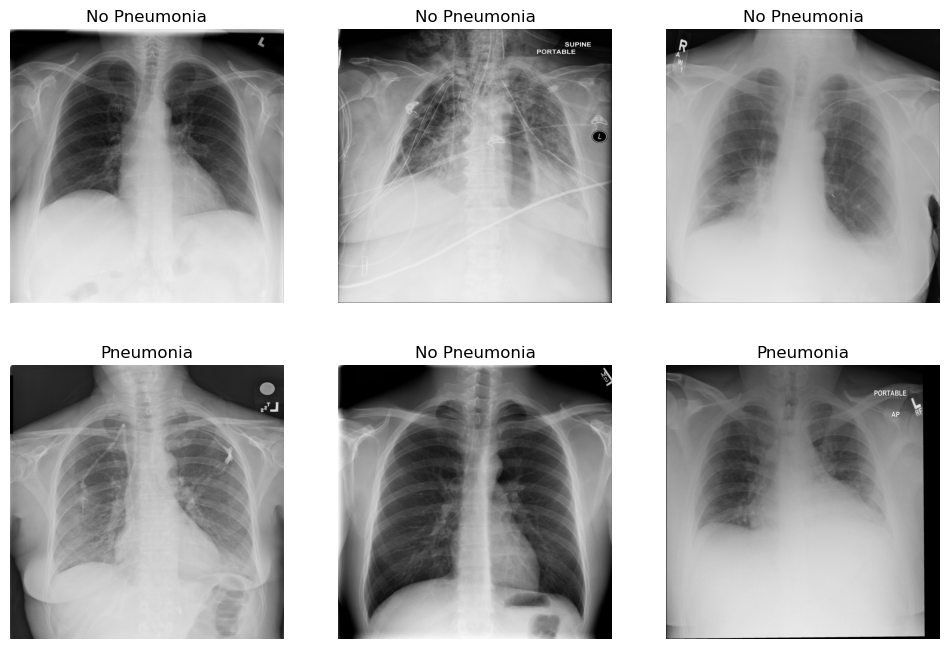

In [11]:
t_x, t_y = next(iter(train_loader))
fig, m_axs = plt.subplots(2, 3, figsize=(12, 8))
for c_x, c_y, c_ax in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x.permute(1, 2, 0), cmap="bone")
    if c_y == 1:
        c_ax.set_title("Pneumonia")
    else:
        c_ax.set_title("No Pneumonia")
    c_ax.axis("off")

## 4. Build model

In [12]:
model = PneumoniaClassifier()

## 5. Train model

In [13]:
def train_model(
    model: LightningModule,
    train_loader: LightningDataModule,
    val_loader: LightningDataModule,
    test_loader: LightningDataModule,
    logs_path: Path,
    epochs: int = 100,
    **kwargs
):
    """Train model

    Args:
        model: Model to train.
        train_loader: Training data loader.
        logs_path: Where to store
        epochs:

    Returns:
        Trainer object.
    """
    trainer = Trainer(
        default_root_dir=logs_path,
        callbacks=[EarlyStopping(monitor="val_loss", patience=10, mode="min")],
        max_epochs=epochs,
        **kwargs
    )

    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    test_results = trainer.test(model=model, dataloaders=test_loader, ckpt_path="best")

    return trainer, test_results

In [14]:
trainer, test_results = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    logs_path=LOGS_PATH,
    epochs=EPOCHS,
    accelerator="gpu",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/uziel/miniconda3/envs/pneumonia_detection/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Missing logger folder: ../data/model_outputs/mobilenet_v3_large/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                   | Params
-----------------------------------------------------------
0 | model       

/home/uziel/miniconda3/envs/pneumonia_detection/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 4/2068 [00:02<20:39,  1.66it/s, loss=1.28, v_num=0]

/home/uziel/miniconda3/envs/pneumonia_detection/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Epoch 0:  26%|██▌       | 535/2068 [02:13<06:21,  4.01it/s, loss=0.679, v_num=0]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 0:  73%|███████▎  | 1503/2068 [05:53<02:13,  4.25it/s, loss=0.679, v_num=0]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 1:  26%|██▌       | 535/2068 [02:14<06:23,  3.99it/s, loss=0.666, v_num=0, val_loss=0.841, val_accuracy=0.311, val_precision=0.0157, val_recall=0.0651, val_f1_score=0.025, val_auroc=0.0491, val_avg_precision=nan.0, val_true_positives=0.0672, val_false_positives=4.120, val_true_negatives=1.800, val_false_negatives=0.00951] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 1:  73%|███████▎  | 1503/2068 [05:54<02:13,  4.24it/s, loss=0.666, v_num=0, val_loss=0.841, val_accuracy=0.311, val_precision=0.0157, val_recall=0.0651, val_f1_score=0.025, val_auroc=0.0491, val_avg_precision=nan.0, val_true_positives=0.0672, val_false_positives=4.120, val_true_negatives=1.800, val_false_negatives=0.00951]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 2:  26%|██▌       | 535/2068 [02:14<06:26,  3.97it/s, loss=0.65, v_num=0, val_loss=0.550, val_accuracy=0.746, val_precision=0.0211, val_recall=0.0378, val_f1_score=0.0258, val_auroc=0.0488, val_avg_precision=nan.0, val_true_positives=0.0392, val_false_positives=1.490, val_true_negatives=4.440, val_false_negatives=0.0375]  

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 2:  73%|███████▎  | 1503/2068 [05:55<02:13,  4.22it/s, loss=0.65, v_num=0, val_loss=0.550, val_accuracy=0.746, val_precision=0.0211, val_recall=0.0378, val_f1_score=0.0258, val_auroc=0.0488, val_avg_precision=nan.0, val_true_positives=0.0392, val_false_positives=1.490, val_true_negatives=4.440, val_false_negatives=0.0375]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 3:  26%|██▌       | 536/2068 [02:17<06:32,  3.90it/s, loss=0.672, v_num=0, val_loss=1.470, val_accuracy=0.135, val_precision=0.0139, val_recall=0.0708, val_f1_score=0.0232, val_auroc=0.0495, val_avg_precision=nan.0, val_true_positives=0.0731, val_false_positives=5.190, val_true_negatives=0.734, val_false_negatives=0.00357]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 3:  73%|███████▎  | 1503/2068 [05:58<02:14,  4.19it/s, loss=0.672, v_num=0, val_loss=1.470, val_accuracy=0.135, val_precision=0.0139, val_recall=0.0708, val_f1_score=0.0232, val_auroc=0.0495, val_avg_precision=nan.0, val_true_positives=0.0731, val_false_positives=5.190, val_true_negatives=0.734, val_false_negatives=0.00357]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 4:  26%|██▌       | 536/2068 [02:15<06:26,  3.96it/s, loss=0.618, v_num=0, val_loss=0.454, val_accuracy=0.816, val_precision=0.0175, val_recall=0.0268, val_f1_score=0.020, val_auroc=0.0513, val_avg_precision=nan.0, val_true_positives=0.0279, val_false_positives=1.060, val_true_negatives=4.870, val_false_negatives=0.0488]   

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 4:  73%|███████▎  | 1503/2068 [05:57<02:14,  4.20it/s, loss=0.618, v_num=0, val_loss=0.454, val_accuracy=0.816, val_precision=0.0175, val_recall=0.0268, val_f1_score=0.020, val_auroc=0.0513, val_avg_precision=nan.0, val_true_positives=0.0279, val_false_positives=1.060, val_true_negatives=4.870, val_false_negatives=0.0488]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 5:  26%|██▌       | 535/2068 [02:13<06:23,  4.00it/s, loss=0.618, v_num=0, val_loss=1.250, val_accuracy=0.331, val_precision=0.0165, val_recall=0.066, val_f1_score=0.0259, val_auroc=0.0518, val_avg_precision=nan.0, val_true_positives=0.0684, val_false_positives=4.010, val_true_negatives=1.920, val_false_negatives=0.00833] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 5:  73%|███████▎  | 1503/2068 [06:05<02:17,  4.12it/s, loss=0.618, v_num=0, val_loss=1.250, val_accuracy=0.331, val_precision=0.0165, val_recall=0.066, val_f1_score=0.0259, val_auroc=0.0518, val_avg_precision=nan.0, val_true_positives=0.0684, val_false_positives=4.010, val_true_negatives=1.920, val_false_negatives=0.00833]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 6:  26%|██▌       | 535/2068 [02:30<07:10,  3.56it/s, loss=0.586, v_num=0, val_loss=1.480, val_accuracy=0.168, val_precision=0.0143, val_recall=0.069, val_f1_score=0.0234, val_auroc=0.0497, val_avg_precision=nan.0, val_true_positives=0.0714, val_false_positives=4.980, val_true_negatives=0.938, val_false_negatives=0.00535] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 6:  73%|███████▎  | 1503/2068 [06:21<02:23,  3.94it/s, loss=0.586, v_num=0, val_loss=1.480, val_accuracy=0.168, val_precision=0.0143, val_recall=0.069, val_f1_score=0.0234, val_auroc=0.0497, val_avg_precision=nan.0, val_true_positives=0.0714, val_false_positives=4.980, val_true_negatives=0.938, val_false_negatives=0.00535]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 7:  26%|██▌       | 536/2068 [02:15<06:28,  3.95it/s, loss=0.472, v_num=0, val_loss=0.556, val_accuracy=0.723, val_precision=0.0186, val_recall=0.0357, val_f1_score=0.0234, val_auroc=0.0497, val_avg_precision=nan.0, val_true_positives=0.0369, val_false_positives=1.620, val_true_negatives=4.300, val_false_negatives=0.0398] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 7:  73%|███████▎  | 1503/2068 [06:02<02:16,  4.14it/s, loss=0.472, v_num=0, val_loss=0.556, val_accuracy=0.723, val_precision=0.0186, val_recall=0.0357, val_f1_score=0.0234, val_auroc=0.0497, val_avg_precision=nan.0, val_true_positives=0.0369, val_false_positives=1.620, val_true_negatives=4.300, val_false_negatives=0.0398]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 8:  26%|██▌       | 536/2068 [02:15<06:27,  3.96it/s, loss=0.449, v_num=0, val_loss=0.658, val_accuracy=0.654, val_precision=0.0192, val_recall=0.0428, val_f1_score=0.0251, val_auroc=0.0514, val_avg_precision=nan.0, val_true_positives=0.044, val_false_positives=2.040, val_true_negatives=3.880, val_false_negatives=0.0327]  

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 8:  73%|███████▎  | 1503/2068 [05:57<02:14,  4.20it/s, loss=0.449, v_num=0, val_loss=0.658, val_accuracy=0.654, val_precision=0.0192, val_recall=0.0428, val_f1_score=0.0251, val_auroc=0.0514, val_avg_precision=nan.0, val_true_positives=0.044, val_false_positives=2.040, val_true_negatives=3.880, val_false_negatives=0.0327]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 9:  26%|██▌       | 536/2068 [02:15<06:28,  3.95it/s, loss=0.553, v_num=0, val_loss=0.539, val_accuracy=0.735, val_precision=0.0198, val_recall=0.0348, val_f1_score=0.0236, val_auroc=0.0481, val_avg_precision=nan.0, val_true_positives=0.0363, val_false_positives=1.550, val_true_negatives=4.370, val_false_negatives=0.0404] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 9:  73%|███████▎  | 1503/2068 [05:58<02:14,  4.19it/s, loss=0.553, v_num=0, val_loss=0.539, val_accuracy=0.735, val_precision=0.0198, val_recall=0.0348, val_f1_score=0.0236, val_auroc=0.0481, val_avg_precision=nan.0, val_true_positives=0.0363, val_false_positives=1.550, val_true_negatives=4.370, val_false_negatives=0.0404]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 10:  26%|██▌       | 535/2068 [02:24<06:55,  3.69it/s, loss=0.375, v_num=0, val_loss=0.275, val_accuracy=0.904, val_precision=0.0181, val_recall=0.0211, val_f1_score=0.019, val_auroc=0.0489, val_avg_precision=nan.0, val_true_positives=0.0226, val_false_positives=0.522, val_true_negatives=5.400, val_false_negatives=0.0541] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 10:  73%|███████▎  | 1503/2068 [06:35<02:28,  3.80it/s, loss=0.375, v_num=0, val_loss=0.275, val_accuracy=0.904, val_precision=0.0181, val_recall=0.0211, val_f1_score=0.019, val_auroc=0.0489, val_avg_precision=nan.0, val_true_positives=0.0226, val_false_positives=0.522, val_true_negatives=5.400, val_false_negatives=0.0541]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 11:  26%|██▌       | 535/2068 [02:31<07:14,  3.53it/s, loss=0.278, v_num=0, val_loss=0.434, val_accuracy=0.802, val_precision=0.0188, val_recall=0.0312, val_f1_score=0.0224, val_auroc=0.0487, val_avg_precision=nan.0, val_true_positives=0.0327, val_false_positives=1.150, val_true_negatives=4.780, val_false_negatives=0.044] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 11:  73%|███████▎  | 1503/2068 [06:39<02:30,  3.76it/s, loss=0.278, v_num=0, val_loss=0.434, val_accuracy=0.802, val_precision=0.0188, val_recall=0.0312, val_f1_score=0.0224, val_auroc=0.0487, val_avg_precision=nan.0, val_true_positives=0.0327, val_false_positives=1.150, val_true_negatives=4.780, val_false_negatives=0.044]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 12:  26%|██▌       | 535/2068 [02:31<07:13,  3.54it/s, loss=0.327, v_num=0, val_loss=0.718, val_accuracy=0.655, val_precision=0.0196, val_recall=0.0428, val_f1_score=0.0256, val_auroc=0.0501, val_avg_precision=nan.0, val_true_positives=0.0446, val_false_positives=2.040, val_true_negatives=3.880, val_false_negatives=0.0321] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 12:  73%|███████▎  | 1503/2068 [06:39<02:30,  3.76it/s, loss=0.327, v_num=0, val_loss=0.718, val_accuracy=0.655, val_precision=0.0196, val_recall=0.0428, val_f1_score=0.0256, val_auroc=0.0501, val_avg_precision=nan.0, val_true_positives=0.0446, val_false_positives=2.040, val_true_negatives=3.880, val_false_negatives=0.0321]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 13:  26%|██▌       | 535/2068 [02:32<07:16,  3.51it/s, loss=0.369, v_num=0, val_loss=1.140, val_accuracy=0.505, val_precision=0.0179, val_recall=0.0541, val_f1_score=0.0261, val_auroc=0.0484, val_avg_precision=nan.0, val_true_positives=0.0559, val_false_positives=2.950, val_true_negatives=2.980, val_false_negatives=0.0208] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 13:  73%|███████▎  | 1503/2068 [06:45<02:32,  3.71it/s, loss=0.369, v_num=0, val_loss=1.140, val_accuracy=0.505, val_precision=0.0179, val_recall=0.0541, val_f1_score=0.0261, val_auroc=0.0484, val_avg_precision=nan.0, val_true_positives=0.0559, val_false_positives=2.950, val_true_negatives=2.980, val_false_negatives=0.0208]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 14:  26%|██▌       | 535/2068 [02:30<07:12,  3.55it/s, loss=0.286, v_num=0, val_loss=1.060, val_accuracy=0.519, val_precision=0.0192, val_recall=0.0523, val_f1_score=0.0267, val_auroc=0.0484, val_avg_precision=nan.0, val_true_positives=0.0541, val_false_positives=2.860, val_true_negatives=3.060, val_false_negatives=0.0226] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 14:  73%|███████▎  | 1503/2068 [06:38<02:29,  3.77it/s, loss=0.286, v_num=0, val_loss=1.060, val_accuracy=0.519, val_precision=0.0192, val_recall=0.0523, val_f1_score=0.0267, val_auroc=0.0484, val_avg_precision=nan.0, val_true_positives=0.0541, val_false_positives=2.860, val_true_negatives=3.060, val_false_negatives=0.0226]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 15:  26%|██▌       | 535/2068 [02:30<07:11,  3.55it/s, loss=0.321, v_num=0, val_loss=0.951, val_accuracy=0.572, val_precision=0.0185, val_recall=0.047, val_f1_score=0.0255, val_auroc=0.0472, val_avg_precision=nan.0, val_true_positives=0.0488, val_false_positives=2.540, val_true_negatives=3.380, val_false_negatives=0.0279]  

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 15:  73%|███████▎  | 1503/2068 [06:40<02:30,  3.75it/s, loss=0.321, v_num=0, val_loss=0.951, val_accuracy=0.572, val_precision=0.0185, val_recall=0.047, val_f1_score=0.0255, val_auroc=0.0472, val_avg_precision=nan.0, val_true_positives=0.0488, val_false_positives=2.540, val_true_negatives=3.380, val_false_negatives=0.0279]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 16:  26%|██▌       | 535/2068 [02:32<07:17,  3.50it/s, loss=0.208, v_num=0, val_loss=0.806, val_accuracy=0.631, val_precision=0.0197, val_recall=0.0446, val_f1_score=0.0262, val_auroc=0.0475, val_avg_precision=nan.0, val_true_positives=0.0464, val_false_positives=2.190, val_true_negatives=3.740, val_false_negatives=0.0303] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 16:  73%|███████▎  | 1503/2068 [06:41<02:31,  3.74it/s, loss=0.208, v_num=0, val_loss=0.806, val_accuracy=0.631, val_precision=0.0197, val_recall=0.0446, val_f1_score=0.0262, val_auroc=0.0475, val_avg_precision=nan.0, val_true_positives=0.0464, val_false_positives=2.190, val_true_negatives=3.740, val_false_negatives=0.0303]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 17:  26%|██▌       | 535/2068 [02:31<07:13,  3.53it/s, loss=0.154, v_num=0, val_loss=0.791, val_accuracy=0.657, val_precision=0.0174, val_recall=0.041, val_f1_score=0.0233, val_auroc=0.0475, val_avg_precision=nan.0, val_true_positives=0.0428, val_false_positives=2.020, val_true_negatives=3.900, val_false_negatives=0.0339]  

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 17:  73%|███████▎  | 1503/2068 [06:41<02:30,  3.75it/s, loss=0.154, v_num=0, val_loss=0.791, val_accuracy=0.657, val_precision=0.0174, val_recall=0.041, val_f1_score=0.0233, val_auroc=0.0475, val_avg_precision=nan.0, val_true_positives=0.0428, val_false_positives=2.020, val_true_negatives=3.900, val_false_negatives=0.0339]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 18:  26%|██▌       | 535/2068 [02:31<07:14,  3.53it/s, loss=0.11, v_num=0, val_loss=1.190, val_accuracy=0.533, val_precision=0.0171, val_recall=0.0482, val_f1_score=0.0243, val_auroc=0.0461, val_avg_precision=nan.0, val_true_positives=0.050, val_false_positives=2.770, val_true_negatives=3.150, val_false_negatives=0.0268]  

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 18:  73%|███████▎  | 1503/2068 [06:39<02:30,  3.76it/s, loss=0.11, v_num=0, val_loss=1.190, val_accuracy=0.533, val_precision=0.0171, val_recall=0.0482, val_f1_score=0.0243, val_auroc=0.0461, val_avg_precision=nan.0, val_true_positives=0.050, val_false_positives=2.770, val_true_negatives=3.150, val_false_negatives=0.0268]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 19:  26%|██▌       | 535/2068 [02:31<07:14,  3.52it/s, loss=0.137, v_num=0, val_loss=0.836, val_accuracy=0.666, val_precision=0.0187, val_recall=0.0395, val_f1_score=0.0241, val_auroc=0.047, val_avg_precision=nan.0, val_true_positives=0.041, val_false_positives=1.970, val_true_negatives=3.960, val_false_negatives=0.0357] 

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 19:  73%|███████▎  | 1503/2068 [06:41<02:30,  3.74it/s, loss=0.137, v_num=0, val_loss=0.836, val_accuracy=0.666, val_precision=0.0187, val_recall=0.0395, val_f1_score=0.0241, val_auroc=0.047, val_avg_precision=nan.0, val_true_positives=0.041, val_false_positives=1.970, val_true_negatives=3.960, val_false_negatives=0.0357]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 19: 100%|██████████| 2068/2068 [09:07<00:00,  3.77it/s, loss=0.137, v_num=0, val_loss=1.080, val_accuracy=0.620, val_precision=0.0185, val_recall=0.0455, val_f1_score=0.0252, val_auroc=0.0476, val_avg_precision=nan.0, val_true_positives=0.047, val_false_positives=2.250, val_true_negatives=3.670, val_false_negatives=0.0297]


Restoring states from the checkpoint path at ../data/model_outputs/mobilenet_v3_large/lightning_logs/version_0/checkpoints/epoch=19-step=7720.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../data/model_outputs/mobilenet_v3_large/lightning_logs/version_0/checkpoints/epoch=19-step=7720.ckpt


Testing DataLoader 0: 100%|██████████| 1869/1869 [07:57<00:00,  3.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6238515973091125     │
│        test_auroc         │    0.04712335020303726    │
│    test_avg_precision     │            nan            │
│       test_f1_score       │   0.024547317996621132    │
│   test_false_negatives    │    0.03425207361578941    │
│   test_false_positives    │    2.2221033573150635     │
│         test_loss         │    1.0704740285873413     │
│      test_precision       │   0.018579965457320213    │
│        test_recall        │   0.041744716465473175    │
│    test_true_negatives    │     3.700562000274658     │
│    test_true_positives    │    0.04227990284562111    │
└───────────────────────────┴───────────────────────────┘

## 6. Evaluate model

In [15]:
def plot_pr_curve(y_true: Tensor, y_pred: Tensor):
    """Plot precision-recall curve

    Args:
        performance_metrics: A dictionary of performance metrics including recall,
            precision and average precision scores.
    """
    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])

    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")

    plt.show()


def smooth(scalars: Iterable[float], weight: float = 0.5) -> Iterable[float]:
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed


def plot_metrics(metrics: pd.DataFrame) -> None:
    """Plot training metrics.

    Args:
        history_df: History dataframe containing scores for each epoch.
    """
    # 0. Prune metrics
    metrics = metrics[
        metrics.columns[metrics.columns.str.contains("|".join(("train", "val")))]
    ]
    train_cols = [c for c in metrics.columns if "train" in c]
    metrics[train_cols] = metrics[train_cols].shift(-1)
    metrics = metrics.dropna(how="all")

    # 1. Plot setup
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
    plot_kwargs = dict(xlabel="Training step", ylabel="Score")

    # 1.1. Losses plot
    loss_cols = metrics.columns[metrics.columns.str.contains("loss")]
    metrics[loss_cols].apply(lambda x: smooth(x, 0.9)).plot(
        ax=axes[0], title="Loss during training", **plot_kwargs
    ).legend(loc="upper right")

    # 1.2. Stats cols
    stats_cols = metrics.columns[
        metrics.columns.str.contains("|".join(("true", "false")))
    ]
    metrics[stats_cols].apply(lambda x: smooth(x, 0.9)).plot(
        ax=axes[1], title="Stats during training", **plot_kwargs
    ).legend(loc="upper right")

    # 1.3. Stats cols
    binary_metrics_cols = metrics.columns.difference(loss_cols).difference(stats_cols)
    metrics[binary_metrics_cols].apply(lambda x: smooth(x, 0.9)).plot(
        ax=axes[2], title="Stats during training", **plot_kwargs
    ).legend(loc="upper right")

    fig.tight_layout()

### Test results

In [16]:
print(test_results)

[{'test_loss': 1.0704740285873413, 'test_accuracy': 0.6238515973091125, 'test_precision': 0.018579965457320213, 'test_recall': 0.041744716465473175, 'test_f1_score': 0.024547317996621132, 'test_auroc': 0.04712335020303726, 'test_avg_precision': nan, 'test_true_positives': 0.04227990284562111, 'test_false_positives': 2.2221033573150635, 'test_true_negatives': 3.700562000274658, 'test_false_negatives': 0.03425207361578941}]


/tmp/ipykernel_31994/1681359343.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics[train_cols] = metrics[train_cols].shift(-1)


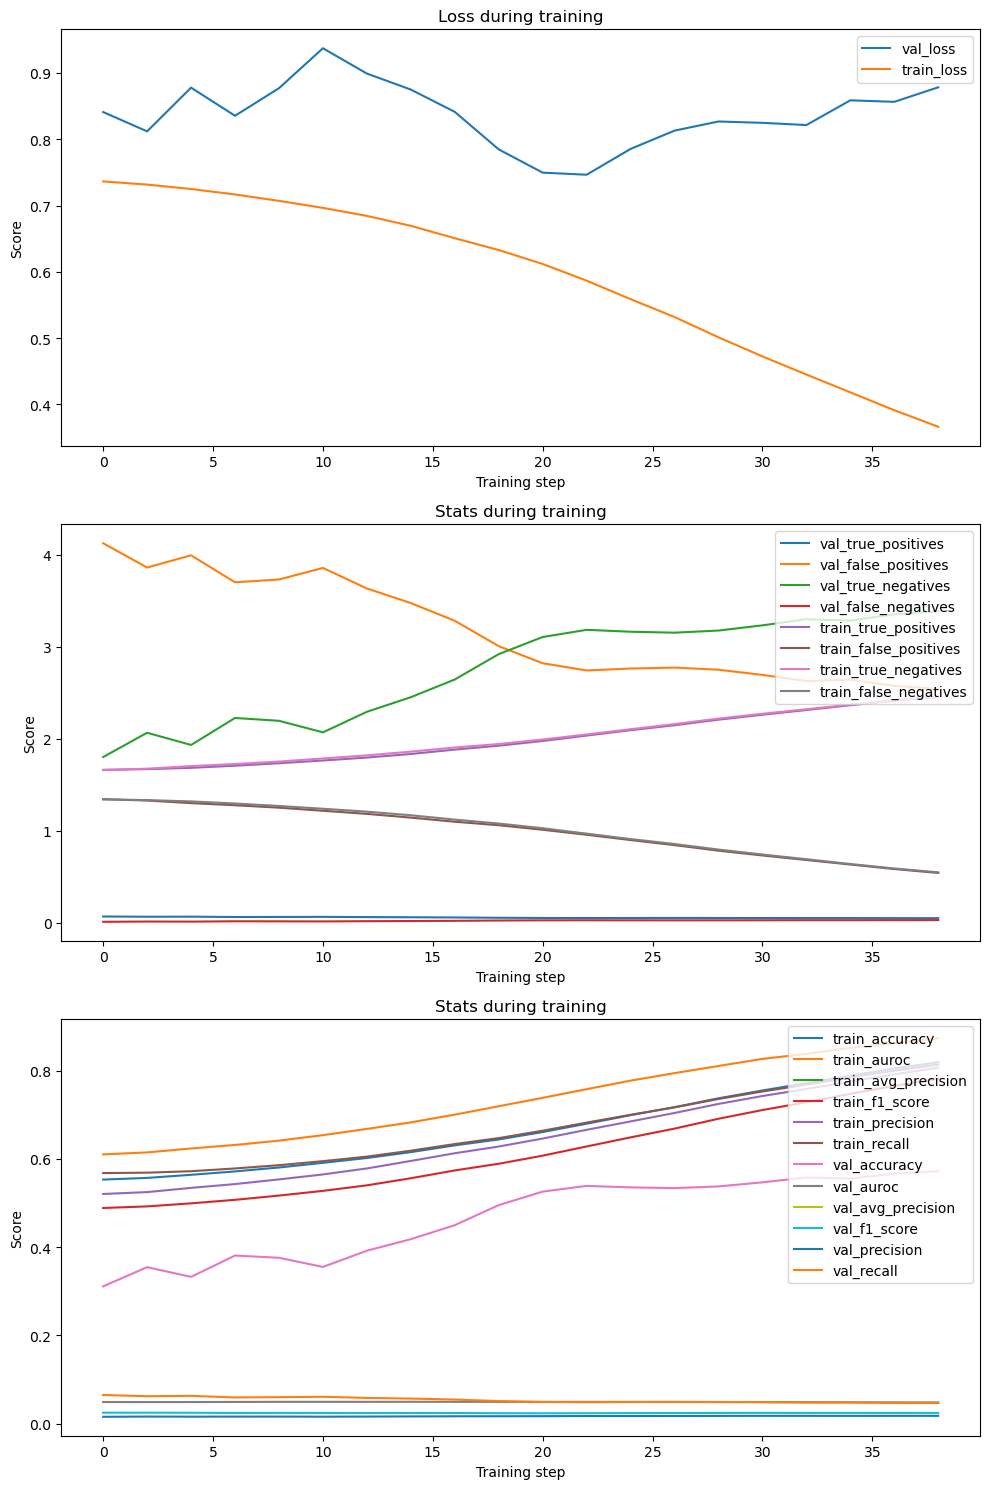

In [17]:
metrics_file = sorted(
    LOGS_PATH.glob("**/metrics.csv"),
    key=lambda file: file.stat().st_mtime,
    reverse=True,
)[0]
metrics = pd.read_csv(metrics_file)
plot_metrics(metrics)

### 6.1. Precision-recall curve

In [18]:
predictions = trainer.predict(model=model, dataloaders=test_loader, ckpt_path="best")
y_true = [int(x) for x in chain(*[targets for img, targets in iter(test_loader)])]
y_scores = [float(x) for x in chain(*predictions)]

Restoring states from the checkpoint path at ../data/model_outputs/mobilenet_v3_large/lightning_logs/version_0/checkpoints/epoch=19-step=7720.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../data/model_outputs/mobilenet_v3_large/lightning_logs/version_0/checkpoints/epoch=19-step=7720.ckpt


Predicting DataLoader 0: 100%|██████████| 1869/1869 [07:31<00:00,  4.14it/s]


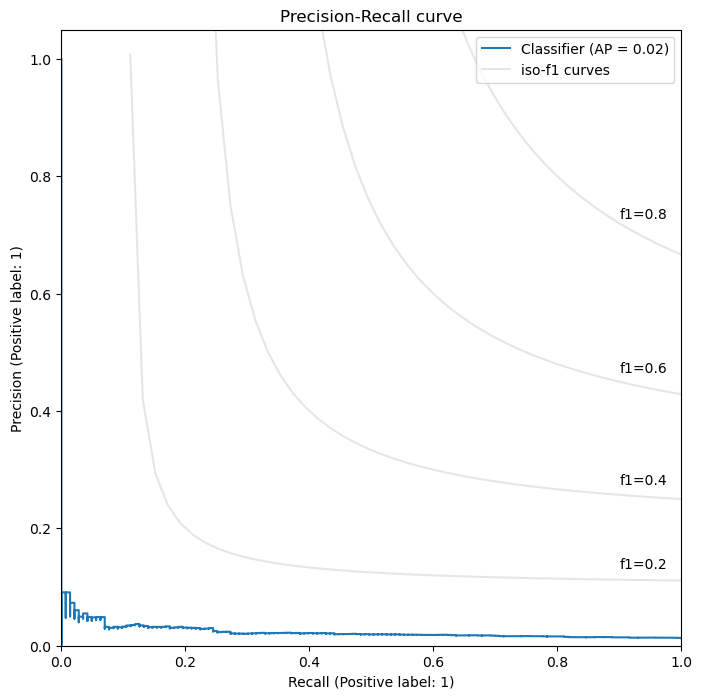

In [19]:
plot_pr_curve(y_true, y_scores)

### 6.2. Find threshold that optimizes recall (sensitivity or true positive rate)

We prioritize recall because high recall tests are good for screening or worklist prioritization, which fit the use case of this medical device.

In [20]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

pr_stats = (
    pd.DataFrame(
        data=precision_recall_curve(y_true, y_scores),
        index=["precision", "recall", "threshold"],
    )
    .transpose()
    .sort_values(["recall", "precision"], ascending=False)
)
pr_stats

,precision,recall,threshold
481,0.013327,1.0,0.001438
480,0.013326,1.0,0.001437
479,0.013325,1.0,0.001432
478,0.013323,1.0,0.001429
477,0.013322,1.0,0.001428
...,...,...,...
11202,0.000000,0.0,0.999945
11203,0.000000,0.0,0.999967
11204,0.000000,0.0,0.999982
11205,0.000000,0.0,0.999983


Because we want to maximize recall over precision, the best threshold is obtained by sorting our thresholds by recall, and then by precision if there is a tie.

In [21]:
best_th = pr_stats["threshold"].iloc[0]

BEST_TH_PATH.write_text(str(best_th))

print(f"The best threshold found was: {best_th}")

The best threshold found was: 0.0014378840569406748


### 6.3. Visualize predicted vs true with the best threshold found

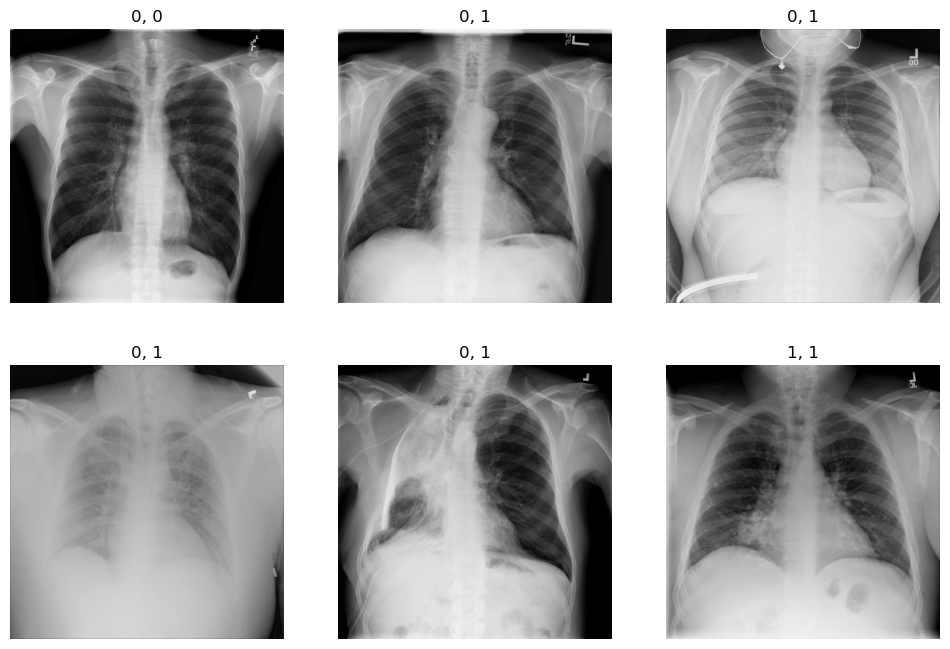

In [22]:
fig, m_axs = plt.subplots(2, 3, figsize=(12, 8))

for i, (c_x, c_y, c_ax) in enumerate(zip(*next(iter(val_loader)), m_axs.flatten())):
    c_ax.imshow(c_x.permute(1, 2, 0), cmap="bone")
    if c_y == 1:
        if y_scores[i] > best_th:
            c_ax.set_title("1, 1")
        else:
            c_ax.set_title("1, 0")
    else:
        if y_scores[i] > best_th:
            c_ax.set_title("0, 1")
        else:
            c_ax.set_title("0, 0")
    c_ax.axis("off")